In [1]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from konlpy.tag import Kkma, Okt
from collections import Counter
from wordcloud import WordCloud

warnings.filterwarnings('ignore')

# 새로운 데이터셋 만드는 과정(전처리)
- 카드 거래 데이터로 새롭게 만든 데이터프레임이 df임(첨부)

### 전체 카드 거래 데이터 양이 너무 많아 고객ID별로 8개의 데이터프레임으로 분리 후 각각 전처리 하여 concat
- 활성화, 신유지 칼럼까지 모두 추가 된 게 df 데이터프레임임

In [3]:
# df_3 = pd.read_csv(r'C:\Users\campus4D028\Desktop\새 폴더 (14)\df_3.csv', encoding = 'utf-8')
# df_4 = pd.read_csv(r'C:\Users\campus4D028\Desktop\새 폴더 (14)\df_4.csv', encoding = 'utf-8')
# df_5 = pd.read_csv(r'C:\Users\campus4D028\Desktop\새 폴더 (14)\df_5.csv', encoding = 'utf-8')
# df_6 = pd.read_csv(r'C:\Users\campus4D028\Desktop\새 폴더 (14)\df_6.csv', encoding = 'utf-8')
# df_7 = pd.read_csv(r'C:\Users\campus4D028\Desktop\새 폴더 (14)\df_7.csv', encoding = 'utf-8')
# df_8 = pd.read_csv(r'C:\Users\campus4D028\Desktop\새 폴더 (14)\df_8.csv', encoding = 'utf-8')
# df_9 = pd.read_csv(r'C:\Users\campus4D028\Desktop\새 폴더 (14)\df_9.csv', encoding = 'utf-8')

In [ ]:
def create_customer_summary(df):
    # df['수치화_승인건수'] = df['승인건수'].map(approval_map)
    
    grouped = df.groupby('고객ID')
    
    first_transaction = grouped['거래년월'].min()
    last_transaction = grouped['거래년월'].max()
    
    active_period = ((last_transaction // 100 - first_transaction // 100) * 12 + 
                 (last_transaction % 100 - first_transaction % 100) + 1)

    total_months = grouped['거래년월'].nunique()
    continuity_ratio = (total_months / active_period * 100).fillna(0)
    
    total_transactions = grouped['수치화_승인건수'].sum()
    transaction_density = (total_transactions / total_months).fillna(0)
    
    inactivity_ratio = (1 - continuity_ratio / 100).fillna(0)
    
    total_gap_months = (active_period - total_months).fillna(0)
    
    total_amount = grouped['승인금액'].sum()
    avg_monthly_amount = (total_amount / total_months).fillna(0)
    avg_monthly_count = (total_transactions / total_months).fillna(0)
    
    most_frequent_category = grouped['가맹점업종명'].agg(lambda x: x.mode()[0])
    
    category_diversity = grouped['가맹점업종명'].nunique()
    
    new_customer = (first_transaction > 202101).astype(int)
    
    most_frequent_region = grouped['가맹점_광역시도'].agg(lambda x: x.mode()[0])
    region_diversity = grouped['가맹점_광역시도'].nunique()
    
    total_transaction_amount = total_amount
    total_transaction_count = total_transactions
    
    summary_df = pd.DataFrame({
        '고객ID': first_transaction.index,  
        '최초거래년월': first_transaction.values,
        '최종거래년월': last_transaction.values,
        '거래활동기간': active_period.values,
        '거래 연속성 비율': continuity_ratio.round(2).values,
        '거래 밀도 지수': transaction_density.round(2).values,
        '비활성화 기간 비율': inactivity_ratio.round(2).values,
        '총 거래 공백 개월수': total_gap_months.values,
        '월평균 거래금액': avg_monthly_amount.round(2).values,
        '월평균 거래건수': avg_monthly_count.round(2).values,
        '최다가맹점업종명': most_frequent_category.values,
        '업종다양성지수': category_diversity.values,
        '신규유입고객': new_customer.values,
        '최다가맹점_광역시도': most_frequent_region.values,
        '거래지역다양성지수': region_diversity.values,
        '총거래금액': total_transaction_amount.values,
        '총거래건수': total_transaction_count.values
    })
    
    return summary_df

df = create_customer_summary(df_2)

### 활성화, 유지 칼럼 생성을 위해 df_2부터 df_9 데이터프레임으로 새로운 데이터프레임 생성
- 그 후 기존 df와 비교하여 필요한 칼럼만 merge할 예정

In [ ]:
def approval_count_to_numeric(approval_count):
    count_dict = {
        '5번이하': 2.5,
        '5번초과 10번이하': 7.5,
        '10번초과 15번이하': 12.5,
        '15번초과 20번이하': 17.5,
        '20번 초과': 22.5
    }
    return count_dict.get(approval_count, 0)  # 범주에 맞는 값을 반환, 없으면 0 반환

def get_first_transaction_month(df):
    return df.groupby('고객ID')['거래년월'].min()

def get_first_transaction_industry(df):
    return df.groupby('고객ID').apply(lambda x: x[x['거래년월'] == x['거래년월'].min()]['가맹점업종명'].unique()).apply(lambda x: ','.join(x))

def get_first_transaction_approval_count(df):
    df['승인건수_numeric'] = df['승인건수'].apply(approval_count_to_numeric)
    return df.groupby('고객ID').apply(lambda x: x[x['거래년월'] == x['거래년월'].min()]['승인건수_numeric'].sum())

def get_first_transaction_approval_amount(df):
    return df.groupby('고객ID').apply(lambda x: x[x['거래년월'] == x['거래년월'].min()]['승인금액'].sum())

def get_nth_transaction_month(df, n):
    def get_nth_month(x, n):
        months = sorted(x['거래년월'].unique())
        return months[n-1] if len(months) >= n else 0
    return df.groupby('고객ID').apply(lambda x: get_nth_month(x, n))

def get_active_month_count(df):
    return df.groupby('고객ID')['거래년월'].nunique()

def get_transaction_periods(df):
    grouped = df.groupby('고객ID')
    
    result = []
    for customer_id, group in grouped:
        transaction_months = sorted(group['거래년월'].unique())
        periods = []
        start_month = transaction_months[0]
        for i in range(1, len(transaction_months)):
            if transaction_months[i] != transaction_months[i-1] + 1:
                periods.append((start_month, transaction_months[i-1]))
                start_month = transaction_months[i]
        periods.append((start_month, transaction_months[-1]))  
        result.append({
            '고객ID': customer_id,
            '거래 월 리스트': transaction_months,
            '연속 거래 구간': periods
        })
    
    return pd.DataFrame(result)

def create_final_dataframe(df):
    first_transaction_month = get_first_transaction_month(df)
    first_transaction_industry = get_first_transaction_industry(df)
    first_transaction_approval_count = get_first_transaction_approval_count(df)
    first_transaction_approval_amount = get_first_transaction_approval_amount(df)
    second_transaction_month = get_nth_transaction_month(df, 2)
    third_transaction_month = get_nth_transaction_month(df, 3)
    fourth_transaction_month = get_nth_transaction_month(df, 4)
    active_month_count = get_active_month_count(df)
    transaction_periods_df = get_transaction_periods(df)
    
    final_df = pd.DataFrame({
        '고객ID': first_transaction_month.index,
        '최초거래년월': first_transaction_month.values,
        '최초가맹점업종명': first_transaction_industry.values,
        '최초거래년월승인건수': first_transaction_approval_count.values,
        '최초거래년월승인금액': first_transaction_approval_amount.values,
        '두번째거래년월': second_transaction_month.values,
        '세번째거래년월': third_transaction_month.values,
        '네번째거래년월': fourth_transaction_month.values,
        '고객별활동개월수': active_month_count.values
    })
    
    final_df = final_df.merge(transaction_periods_df[['고객ID', '거래 월 리스트', '연속 거래 구간']], on='고객ID', how='left')
    
    return final_df

def determine_activation(row):
    if row["최초거래년월"] == 202101:
        return "기존고객"
    elif row["두번째거래년월"] == 0:
        return 0
    else:
        first_year, first_month = divmod(row["최초거래년월"], 100)
        second_year, second_month = divmod(row["두번째거래년월"], 100)
        
        if (second_year == first_year and second_month == first_month + 1) or \
           (second_year == first_year + 1 and first_month == 12 and second_month == 1):
            return row["최초거래년월"]
        else:
            return 0

# def is_consecutive_months(months):
#     if 0 in months:
#         return False
#     for i in range(len(months) - 1):
#         current_year, current_month = divmod(months[i], 100)
#         next_year, next_month = divmod(months[i + 1], 100)
#         if not ((current_year == next_year and next_month == current_month + 1) or 
#                 (next_year == current_year + 1 and current_month == 12 and next_month == 1)):
#             return False
#     return True

def determine_retention(row):
    if row["최초거래년월"] == 202101:
        return "기존고객"
    
    months = [row["최초거래년월"], row["두번째거래년월"], row["세번째거래년월"], row["네번째거래년월"]]
    if is_consecutive_months(months):
        return row["최초거래년월"]
    else:
        return 0

final_df = pd.DataFrame()

### df_2부터 df_9까지 적용

In [ ]:
for i in range(2, 10):
    df = globals().get(f"df_{i}")
    
    temp_df = create_final_dataframe(df)
    temp_df["활성화"] = temp_df.apply(determine_activation, axis=1)
    #temp_df['거래 연속성 점수'] = temp_df['연속 거래 구간'].apply(lambda x: calculate_recency_score(x))
    temp_df["신유지"] = temp_df.apply(determine_retention, axis=1)
    final_df = pd.concat([final_df, temp_df], ignore_index=True)

# 고객별(91만명) 데이터 -> df

In [17]:
df = pd.read_csv(r'C:\Users\campus4D028\Desktop\df.csv', encoding = 'utf-8')

In [45]:
df.head(2)

,고객ID,최초거래년월,최종거래년월,거래활동기간,거래 연속성 비율,거래 밀도 지수,비활성화 기간 비율,총 거래 공백 개월수,월평균 거래금액,월평균 거래건수,...,거래월점수,연속구간점수,Cluster,활성화,신유지,두번째거래년월,세번째거래년월,네번째거래년월,활성화2,신유지2
0,2002967708,202312,202312,1,100.0,5.0,0.0,0,210000.0,5.0,...,33.115,1.0,2,0,0,0,0,0,활성화x,신유지x
1,2004066711,202312,202312,1,100.0,2.5,0.0,0,40000.0,2.5,...,33.115,1.0,2,0,0,0,0,0,활성화x,신유지x


# 활성화 시각화
- 202102월 부터 202311월까지의 활성화 시각화

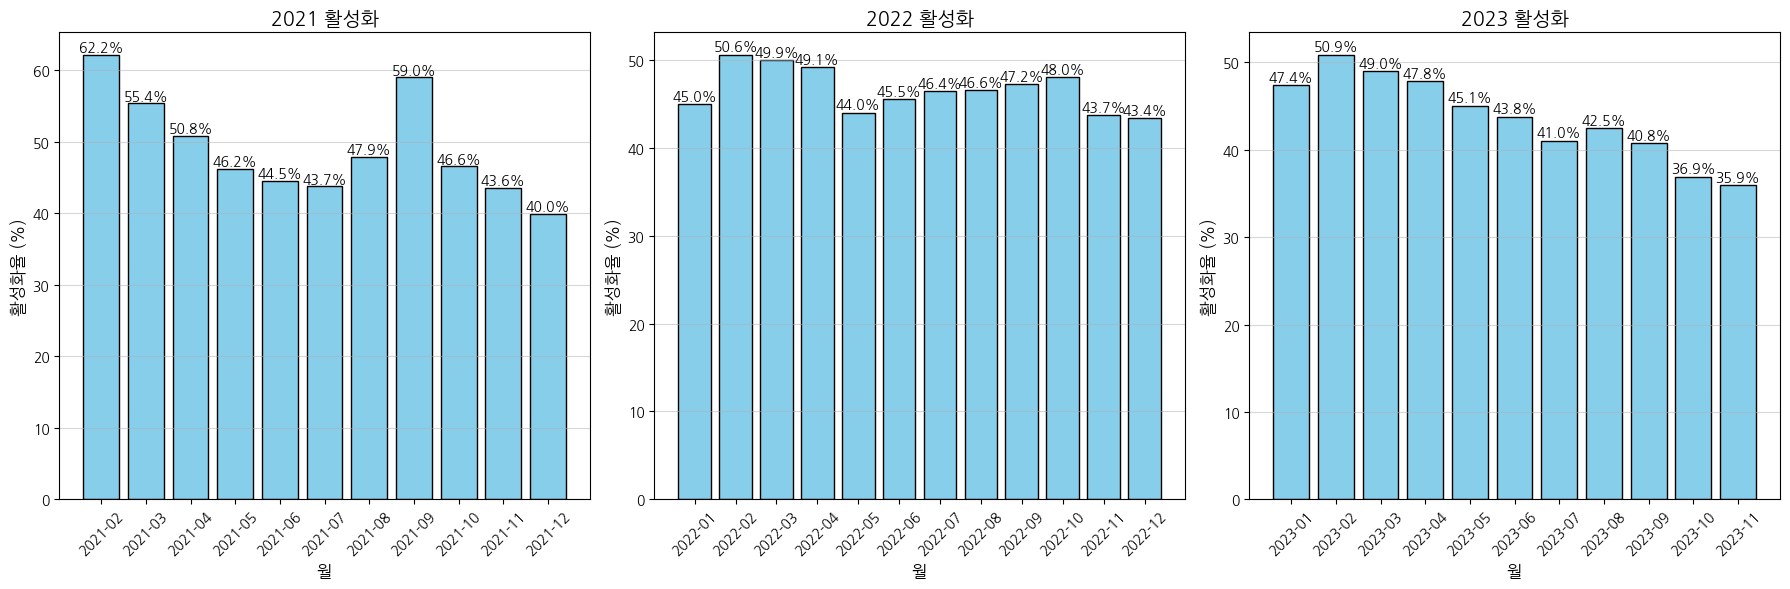

In [18]:
# 202102 - 202112
activation_rates_2021 = []
months_2021 = [f"2021-{str(month)[4:]}" for month in range(202102, 202112 + 1)]

for month in range(202102, 202112 + 1):
    denominator = len(df[df['최초거래년월'] == month])
    numerator = len(df[(df['최초거래년월'] == month) & (df['활성화'] == str(month))])
    activation_rate = (numerator / denominator * 100) if denominator > 0 else 0
    activation_rates_2021.append(activation_rate)

# 202201 - 202212
activation_rates_2022 = []
months_2022 = [f"2022-{str(month)[4:]}" for month in range(202201, 202212 + 1)]

for month in range(202201, 202212 + 1):
    denominator = len(df[df['최초거래년월'] == month])
    numerator = len(df[(df['최초거래년월'] == month) & (df['활성화'] == str(month))])
    activation_rate = (numerator / denominator * 100) if denominator > 0 else 0
    activation_rates_2022.append(activation_rate)

# 202301 - 202311
activation_rates_2023 = []
months_2023 = [f"2023-{str(month)[4:]}" for month in range(202301, 202311 + 1)]

for month in range(202301, 202311 + 1):
    denominator = len(df[df['최초거래년월'] == month])
    numerator = len(df[(df['최초거래년월'] == month) & (df['활성화'] == str(month))])
    activation_rate = (numerator / denominator * 100) if denominator > 0 else 0
    activation_rates_2023.append(activation_rate)

# 3년치 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 2021년
axes[0].bar(months_2021, activation_rates_2021, color='skyblue', edgecolor='black')
axes[0].set_title('2021 활성화', fontsize=14)
axes[0].set_xlabel('월', fontsize=12)
axes[0].set_ylabel('활성화율 (%)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.5)
for i, rate in enumerate(activation_rates_2021):
    axes[0].text(i, rate + 0.5, f'{rate:.1f}%', ha='center', fontsize=10)

# 2022년
axes[1].bar(months_2022, activation_rates_2022, color='skyblue', edgecolor='black')
axes[1].set_title('2022 활성화', fontsize=14)
axes[1].set_xlabel('월', fontsize=12)
axes[1].set_ylabel('활성화율 (%)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.5)
for i, rate in enumerate(activation_rates_2022):
    axes[1].text(i, rate + 0.5, f'{rate:.1f}%', ha='center', fontsize=10)

# 2023년
axes[2].bar(months_2023, activation_rates_2023, color='skyblue', edgecolor='black')
axes[2].set_title('2023 활성화', fontsize=14)
axes[2].set_xlabel('월', fontsize=12)
axes[2].set_ylabel('활성화율 (%)', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.5)
for i, rate in enumerate(activation_rates_2023):
    axes[2].text(i, rate + 0.5, f'{rate:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# 유지율 시각화
- 202102월 부터 202309월까지의 유지율 시각화

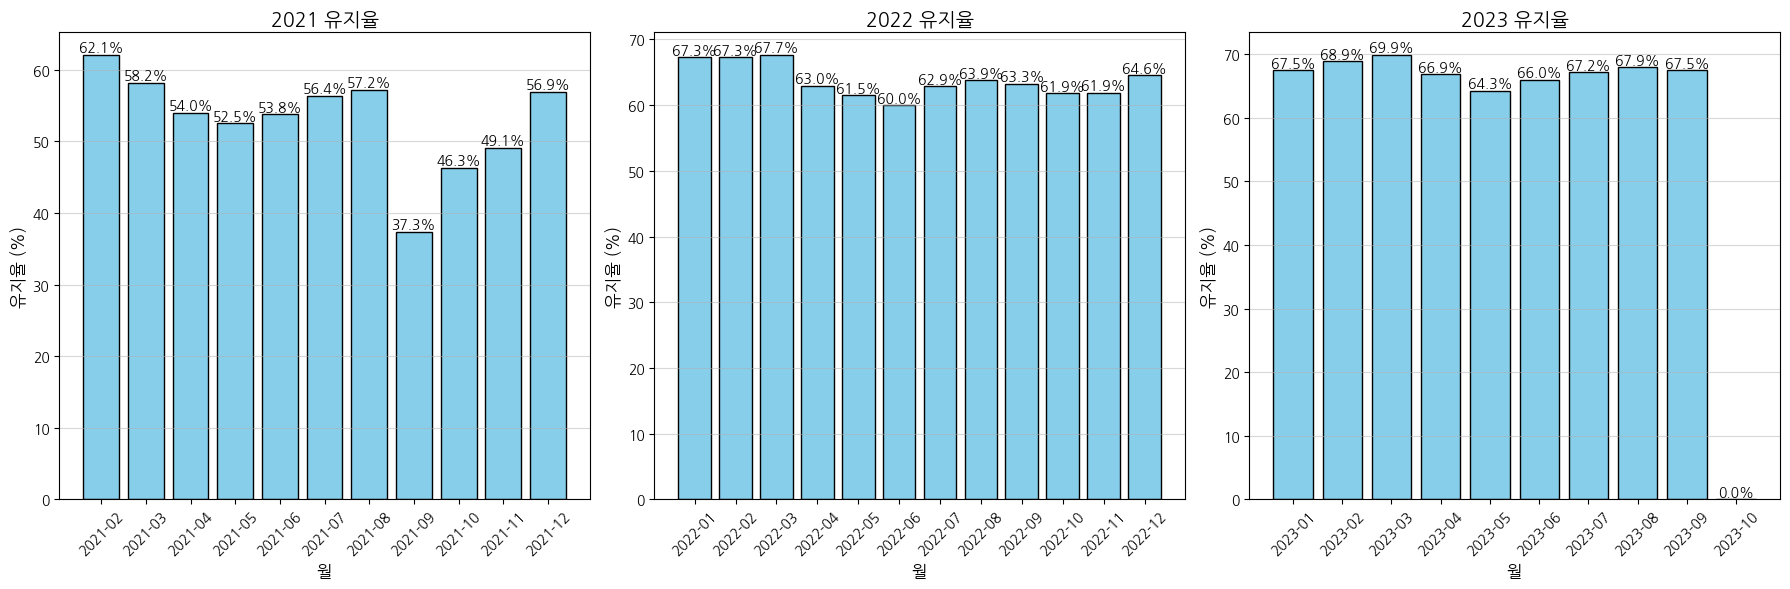

In [19]:
# 202102 - 202112
retention_rates_2021 = []
months_2021 = [f"2021-{str(month)[4:]}" for month in range(202102, 202112 + 1)]

for month in range(202102, 202112 + 1):
    denominator = len(df[df['활성화'] == str(month)])
    numerator = len(df[(df['활성화'] == str(month)) & (df['신유지'] == str(month))])
    retention_rate = (numerator / denominator * 100) if denominator > 0 else 0
    retention_rates_2021.append(retention_rate)

# 202201 - 202212
retention_rates_2022 = []
months_2022 = [f"2022-{str(month)[4:]}" for month in range(202201, 202212 + 1)]

for month in range(202201, 202212 + 1):
    denominator = len(df[df['활성화'] == str(month)])
    numerator = len(df[(df['활성화'] == str(month)) & (df['신유지'] == str(month))])
    retention_rate = (numerator / denominator * 100) if denominator > 0 else 0
    retention_rates_2022.append(retention_rate)

# 202301 - 202309
retention_rates_2023 = []
months_2023 = [f"2023-{str(month)[4:]}" for month in range(202301, 202310 + 1)]

for month in range(202301, 202310 + 1):
    denominator = len(df[df['활성화'] == str(month)])
    numerator = len(df[(df['활성화'] == str(month)) & (df['신유지'] == str(month))])
    retention_rate = (numerator / denominator * 100) if denominator > 0 else 0
    retention_rates_2023.append(retention_rate)

# 3년치 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 2021년 
axes[0].bar(months_2021, retention_rates_2021, color='skyblue', edgecolor='black')
axes[0].set_title('2021 유지율', fontsize=14)
axes[0].set_xlabel('월', fontsize=12)
axes[0].set_ylabel('유지율 (%)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.5)
for i, rate in enumerate(retention_rates_2021):
    axes[0].text(i, rate + 0.5, f'{rate:.1f}%', ha='center', fontsize=10)

# 2022년
axes[1].bar(months_2022, retention_rates_2022, color='skyblue', edgecolor='black')
axes[1].set_title('2022 유지율', fontsize=14)
axes[1].set_xlabel('월', fontsize=12)
axes[1].set_ylabel('유지율 (%)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.5)
for i, rate in enumerate(retention_rates_2022):
    axes[1].text(i, rate + 0.5, f'{rate:.1f}%', ha='center', fontsize=10)

# 2023년
axes[2].bar(months_2023, retention_rates_2023, color='skyblue', edgecolor='black')
axes[2].set_title('2023 유지율', fontsize=14)
axes[2].set_xlabel('월', fontsize=12)
axes[2].set_ylabel('유지율 (%)', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.5)
for i, rate in enumerate(retention_rates_2023):
    axes[2].text(i, rate + 0.5, f'{rate:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# 202109 이탈고객과 그렇지 않은 고객에 대한 연령대 분포 차이
- df1 : 202109 유입되고 다음 월에 거래를 했지만 11월부터 이탈한 고객
- df4 : 202109 유입된 고객
- df5 : df4 - df1 한 고객
- 카이제곱 검정

In [23]:
df4 = df[
    (df["최초거래년월"] == 202109)
]

df1 = df[
    (df["최초거래년월"] == 202109) &  # 최초거래년월이 202109인 경우
    (df["두번째거래년월"] == 202110) &  # 두번째거래년월이 202110인 경우
    (df['세번째거래년월'] != 202111)
]

df5 = df4[~df4['고객ID'].isin(df1['고객ID'])]

print(len(df4), len(df1), len(df5))

23157 6166 16991


In [24]:
df11 = df1.copy()
df55 = df5.copy()

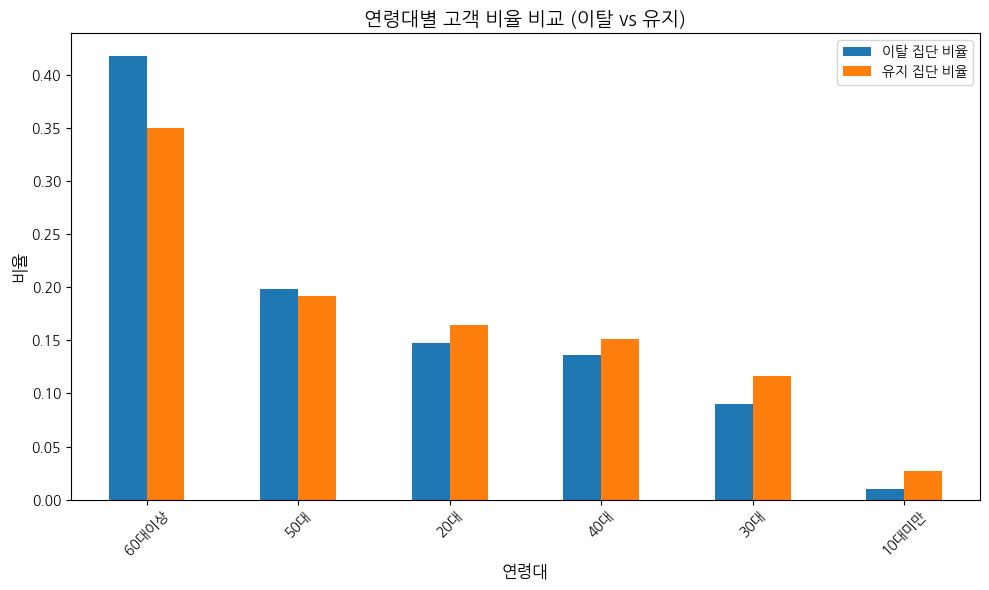

=== 카이제곱 독립성 검정 결과 ===
Chi-squared statistic: 158.65
p-value: 0.0000
Degrees of freedom: 5
=> 두 집단 간 연령대 분포에 통계적으로 유의미한 차이가 있습니다.


In [25]:
df11_counts = df11['연령대'].value_counts()
df55_counts = df55['연령대'].value_counts()

df11_total = len(df11)
df55_total = len(df55)

age_distribution_ratio = pd.DataFrame({
    "df11_ratio": df11_counts / df11_total,
    "df55_ratio": df55_counts / df55_total
}).fillna(0)

age_distribution_ratio.plot(kind='bar', figsize=(10, 6))
plt.title("연령대별 고객 비율 비교 (이탈 vs 유지)", fontsize=14)
plt.xlabel("연령대", fontsize=12)
plt.ylabel("비율", fontsize=12)
plt.xticks(rotation=45)
plt.legend(["이탈 집단 비율", "유지 집단 비율"])
plt.tight_layout()
plt.show()

observed = pd.DataFrame({
    "df11": df11_counts,
    "df55": df55_counts
}).fillna(0).astype(int).values

chi2, p, dof, expected = stats.chi2_contingency(observed)

print("=== 카이제곱 독립성 검정 결과 ===")
print(f"Chi-squared statistic: {chi2:.2f}")
print(f"p-value: {p:.4f}")
print(f"Degrees of freedom: {dof}")

if p < 0.05:
    print("=> 두 집단 간 연령대 분포에 통계적으로 유의미한 차이가 있습니다.")
else:
    print("=> 두 집단 간 연령대 분포에 유의미한 차이가 없습니다.")

###  202109 이탈고객과 그렇지 않은 고객에 대한 60대 이상 비율 차이 검정
- z검정

In [26]:
df11_60대이상 = (df11['연령대'] == '60대이상').sum()
df55_60대이상 = (df55['연령대'] == '60대이상').sum()

counts = np.array([df11_60대이상, df55_60대이상])
nobs = np.array([df11_total, df55_total])

z_stat, p_value = proportions_ztest(counts, nobs)

print("=== 두 비율 비교를 위한 z-검정 결과 ===")
print(f"이탈집단의 60대 이상 비율: {df11_60대이상 / df11_total:.2%}")
print(f"유지집단의 60대 이상 비율: {df55_60대이상 / df55_total:.2%}")
print(f"z-statistic: {z_stat:.2f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("=> 두 집단의 60대 이상 비율에 통계적으로 유의미한 차이가 있습니다.")
    # 비율 비교
    if (df11_60대이상 / df11_total) > (df55_60대이상 / df55_total):
        print("=> 이탈집단에서 60대 이상의 비율이 더 높습니다.")
    else:
        print("=> df55에서 60대 이상의 비율이 더 높습니다.")
else:
    print("=> 두 집단의 60대 이상 비율에 유의미한 차이가 없습니다.")

=== 두 비율 비교를 위한 z-검정 결과 ===
이탈집단의 60대 이상 비율: 41.79%
유지집단의 60대 이상 비율: 34.97%
z-statistic: 9.52
p-value: 0.0000
=> 두 집단의 60대 이상 비율에 통계적으로 유의미한 차이가 있습니다.
=> 이탈집단에서 60대 이상의 비율이 더 높습니다.


# 202109 기사 크롤링 및 워드클라우드
- 크롤링 결과는 출력 x
- 크롤링 후 데이터프레임 저장한 건 df_word 로 저장

In [ ]:
driver = uc.Chrome()

In [ ]:
driver.get("https://search.naver.com/search.naver?where=news&query=%EB%8C%80%EA%B5%AC%EC%9D%80%ED%96%89&sm=tab_opt&sort=0&photo=0&field=0&pd=3&ds=2021.11.01&de=2021.12.31&docid=&related=0&mynews=0&office_type=0&office_section_code=0&news_office_checked=&nso=so%3Ar%2Cp%3Afrom20211101to20211231&is_sug_officeid=0&office_category=0&service_area=0")

In [ ]:
html = BeautifulSoup(driver.page_source, "html.parser")

In [ ]:
title = []
for i in html.find_all("div", class_ = 'news_contents'):
    title.append(i.find("a", class_ = 'news_tit').text)
title

In [ ]:
script = []
for i in html.find_all("div", class_ = 'news_contents'):
    script.append(i.find("div", class_ = 'news_dsc').text)
script

In [ ]:
df_word = pd.DataFrame({
    "Title": title,
    "Content": script
})

In [28]:
df_word = pd.read_csv(r'C:\Users\campus4D028\Desktop\새 폴더 (16)\df_word.csv', encoding = 'utf-8')
df_word.head(2)

,Unnamed: 0,Title,Content
0,0,"대구은행, DGB IM뱅크 스크린골프 대회 개최","DGB대구은행(이하 대구은행)은 창립 54주년 및 독도의 날을 기념, MZ세대 ..."
1,1,"대구은행, 10월부터 비대면 IRP수수료 전액 면제",DGB대구은행은 10월부터 비대면 개인형퇴직연금(IRP) 신규 고객을 대상으로 ...


In [29]:
okt = Okt()
im_nouns = []

for i in range(len(df_word)):
    a = df_word.iloc[i]['Content']
    nouns = okt.nouns(a)
    im_nouns.append(nouns)

df_word['Nouns'] = im_nouns
df_word.head(2)

,Unnamed: 0,Title,Content,Nouns
0,0,"대구은행, DGB IM뱅크 스크린골프 대회 개최","DGB대구은행(이하 대구은행)은 창립 54주년 및 독도의 날을 기념, MZ세대 ...","[대구, 은행, 이하, 대구, 은행, 은, 창립, 주년, 및, 독도, 날, 기념, ..."
1,1,"대구은행, 10월부터 비대면 IRP수수료 전액 면제",DGB대구은행은 10월부터 비대면 개인형퇴직연금(IRP) 신규 고객을 대상으로 ...,"[은행, 비대, 개인, 퇴직, 연금, 신규, 고객, 대상, 수수료, 전액, 면제, ..."


In [36]:
all_nouns = [noun for sublist in df_word['Nouns'] for noun in sublist]

filtered_nouns = [
    noun for noun in all_nouns
    if len(noun) > 1 and
       '은행' not in noun and
       '대구' not in noun and
       '금융' not in noun and
       '지역' not in noun and
       '경기' not in noun and
       '광주' not in noun and
       '울산' not in noun and
       '부산' not in noun and
       '수원' not in noun and
       '한국' not in noun and
       '이번' not in noun and
        '농협' not in noun and
        '기업' not in noun and
       '전북' not in noun and
        '지난' not in noun and
        '위해' not in noun and
        '진행' not in noun and
        '지원' not in noun and
        '리그' not in noun and
        '제공' not in noun and
       '경남' not in noun and
    '파크' not in noun and 
    '하나원' not in noun and
    '현지' not in noun and
    '오후' not in noun
]


noun_counts = Counter(filtered_nouns)

top_10_nouns = noun_counts.most_common(10)

print(top_10_nouns)

[('채용', 454), ('대출', 323), ('투자', 213), ('상품권', 205), ('협약', 203), ('카드', 198), ('증권', 195), ('페이', 193), ('행사', 190), ('추석', 185)]


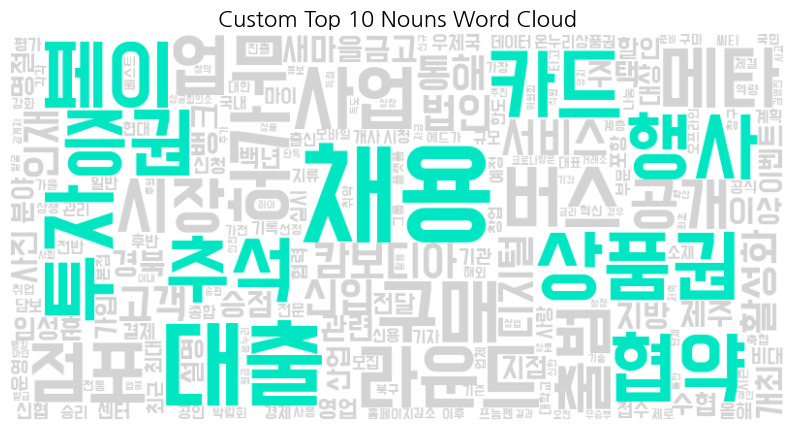

In [37]:
def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    top_5_words = [item[0] for item in noun_counts.most_common(10)]  
    if word in top_5_words:
        return "rgb(0, 230, 195)"  
    else:
        return "lightgray"  

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    font_path=r'C:\Users\campus4D028\Desktop\새 폴더 (11)\텍스트마이닝\BMDOHYEON_ttf.ttf',
    color_func=custom_color_func
).generate_from_frequencies(noun_counts)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("Custom Top 10 Nouns Word Cloud", fontsize=16)
plt.show()

# 군집분석
- 거래 월 점수, 연속 구간 점수 생성 및 정규화 진행
- elbow 보고 4개의 군집을, 우측 군집으로 갈수록 점차 진해지게끔 설정
- 군집별 EDA

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


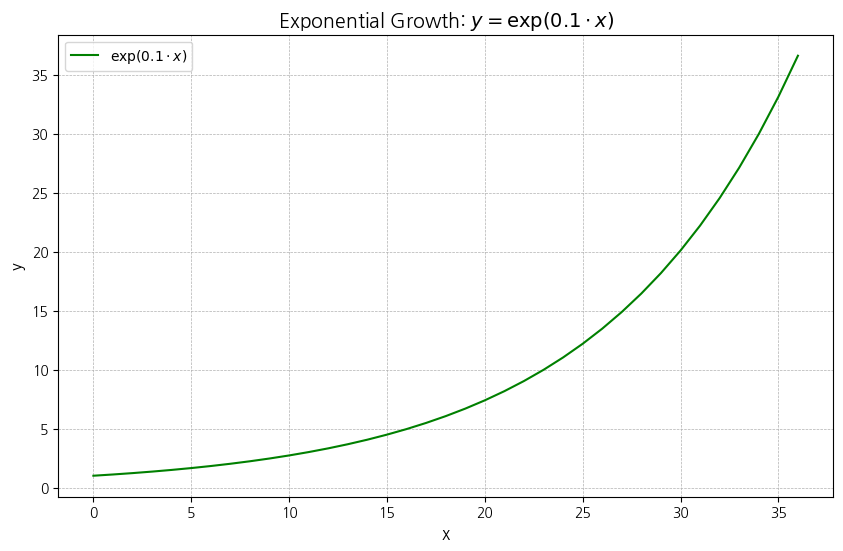

In [40]:
x = np.arange(0, 37)
y = np.exp(0.1 * x)

plt.figure(figsize=(10, 6))
plt.plot(x, y, color='g', linestyle='-', label=r'$\exp(0.1 \cdot x)$')
plt.title('Exponential Growth: $y = \exp(0.1 \cdot x)$', fontsize=14)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [7]:
df['거래월점수'] = df['거래월점수'].round(3)

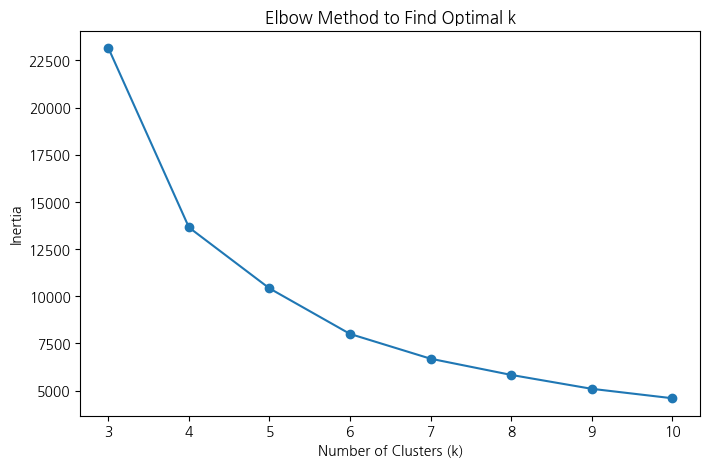

Cluster Summary (Mean Values):
                 고객ID       거래월점수     연속구간점수
Cluster                                     
0        6.319086e+09  158.393589   7.221237
1        7.011345e+09  336.323915  32.367038
2        6.195448e+09   30.508951   2.936512
3        6.638066e+09  295.554363  11.000313

Customer counts per cluster:
Cluster
2    294272
1    259719
3    198452
0    162774
Name: count, dtype: int64


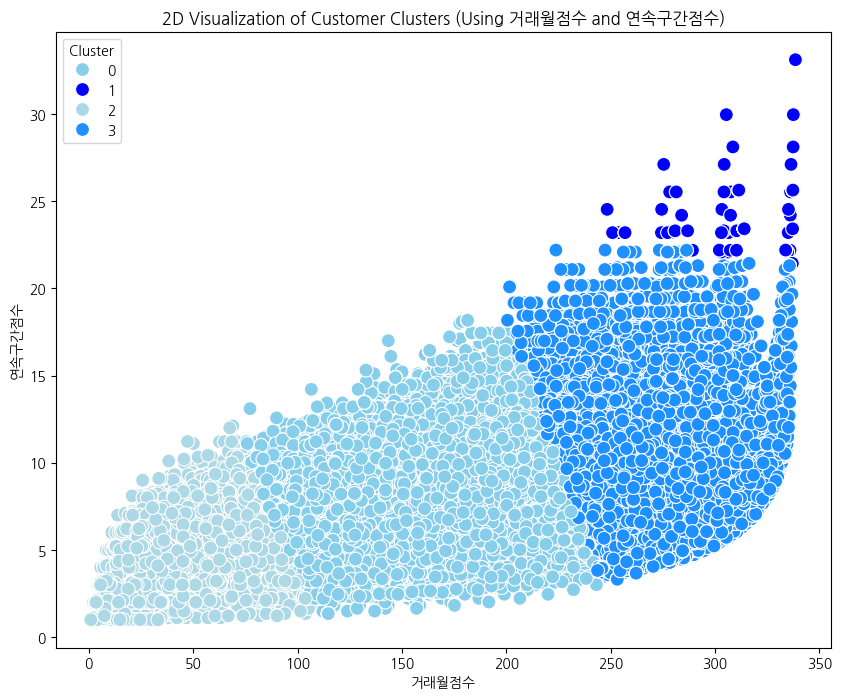


Customer IDs with their assigned Cluster:
         고객ID  Cluster
0  2002967708        2
1  2004066711        2
2  2004166649        2
3  2004326617        2
4  2004432929        2

Merged DataFrame with Cluster Info:
         고객ID  최초거래년월  최종거래년월  거래활동기간  거래 연속성 비율  거래 밀도 지수  비활성화 기간 비율  \
0  2002967708  202312  202312       1      100.0       5.0         0.0   
1  2004066711  202312  202312       1      100.0       2.5         0.0   
2  2004166649  202312  202312       1      100.0      15.0         0.0   
3  2004326617  202312  202312       1      100.0       2.5         0.0   
4  2004432929  202312  202312       1      100.0       5.0         0.0   

   총 거래 공백 개월수  월평균 거래금액  월평균 거래건수  ... 첫 고객등급  연령대  성별  자택_시도   자택_시군구  \
0            0  210000.0       5.0  ...   일반등급  50대   남  대구광역시      수성구   
1            0   40000.0       2.5  ...   일반등급  40대   여  인천광역시      부평구   
2            0  220000.0      15.0  ...   일반등급  20대   남   경상북도      경주시   
3            0   10000.0       2.5  .

In [9]:
df2 = df[['고객ID', '거래월점수', '연속구간점수']].copy()

scaler = MinMaxScaler()
df2_scaled = scaler.fit_transform(df2[['거래월점수', '연속구간점수']])

inertia = []
k_range = range(3, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df2_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Find Optimal k')
plt.show()

optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df2['Cluster'] = kmeans.fit_predict(df2_scaled)

cluster_summary = df2.groupby('Cluster').mean()
print("Cluster Summary (Mean Values):")
print(cluster_summary)

cluster_counts = df2['Cluster'].value_counts()
print("\nCustomer counts per cluster:")
print(cluster_counts)

cluster_colors = {2: mcolors.to_rgba('lightblue', alpha=1), 0: mcolors.to_rgba('skyblue', alpha=1), 
                  3: mcolors.to_rgba('dodgerblue', alpha=1), 1: mcolors.to_rgba('blue', alpha=1)}

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='거래월점수', y='연속구간점수', hue='Cluster', data=df2, palette=cluster_colors, s=100
)
plt.title('2D Visualization of Customer Clusters (Using 거래월점수 and 연속구간점수)')
plt.xlabel('거래월점수')
plt.ylabel('연속구간점수')
plt.legend(title='Cluster')
plt.show()

print("\nCustomer IDs with their assigned Cluster:")
print(df2[['고객ID', 'Cluster']].head())

df = df.merge(df2[['고객ID', 'Cluster']], on='고객ID', how='left')

print("\nMerged DataFrame with Cluster Info:")
print(df.head())

In [36]:
df['신유지'] = df['신유지'].apply(lambda x: 123 if x == '기존고객' else pd.to_numeric(x, errors='coerce')).astype(int)
df['활성화'] = df['활성화'].apply(lambda x: 123 if x == '기존고객' else pd.to_numeric(x, errors='coerce')).astype(int)

In [37]:
df['활성화'] = df['활성화'].astype(str)
df['신유지'] = df['신유지'].astype(str)

In [38]:
df['활성화2'] = df['활성화'].apply(lambda x: '기존고객' if x == '123' else ('활성화x' if x == '0' else '활성화o'))

# 신유지2 칼럼 생성
df['신유지2'] = df['신유지'].apply(lambda x: '기존고객' if x == '123' else ('신유지x' if x == '0' else '신유지o'))

df.head(2)

,고객ID,최초거래년월,최종거래년월,거래활동기간,거래 연속성 비율,거래 밀도 지수,비활성화 기간 비율,총 거래 공백 개월수,월평균 거래금액,월평균 거래건수,...,거래월점수,연속구간점수,Cluster,활성화,신유지,두번째거래년월,세번째거래년월,네번째거래년월,활성화2,신유지2
0,2002967708,202312,202312,1,100.0,5.0,0.0,0,210000.0,5.0,...,33.115,1.0,2,0,0,0,0,0,활성화x,신유지x
1,2004066711,202312,202312,1,100.0,2.5,0.0,0,40000.0,2.5,...,33.115,1.0,2,0,0,0,0,0,활성화x,신유지x


### 군집별 월평균 거래금액

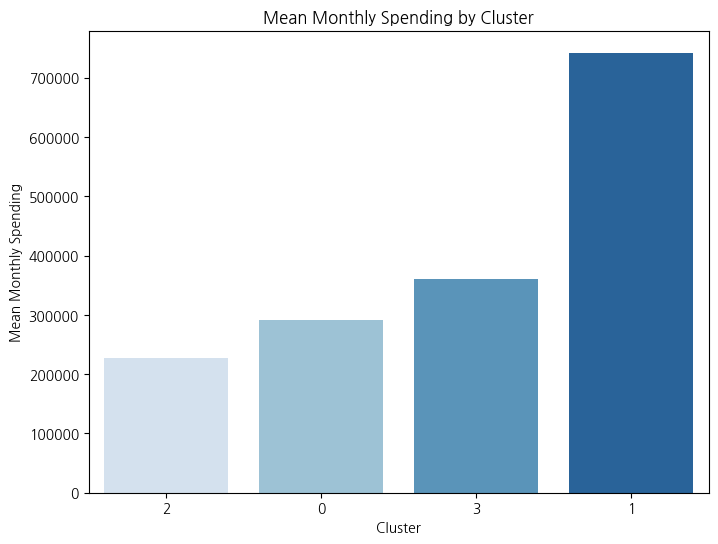

In [39]:
mean_spending_by_cluster = {
    2: df[df['Cluster'] == 2]['월평균 거래금액'].mean(),
    0: df[df['Cluster'] == 0]['월평균 거래금액'].mean(),
    3: df[df['Cluster'] == 3]['월평균 거래금액'].mean(),
    1: df[df['Cluster'] == 1]['월평균 거래금액'].mean()
}

mean_spending_df = pd.DataFrame(list(mean_spending_by_cluster.items()), columns=['Cluster', 'Mean Monthly Spending'])

cluster_order = [2, 0, 3, 1]

plt.figure(figsize=(8, 6))
sns.barplot(x='Cluster', y='Mean Monthly Spending', data=mean_spending_df, palette='Blues', order=cluster_order)
plt.title('Mean Monthly Spending by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Mean Monthly Spending')
plt.show()

### 군집별 신규고객, 기존고객

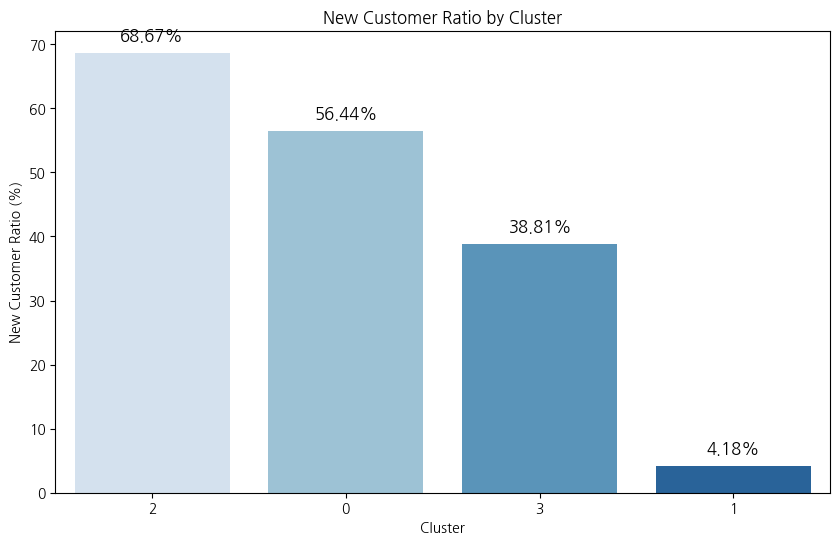

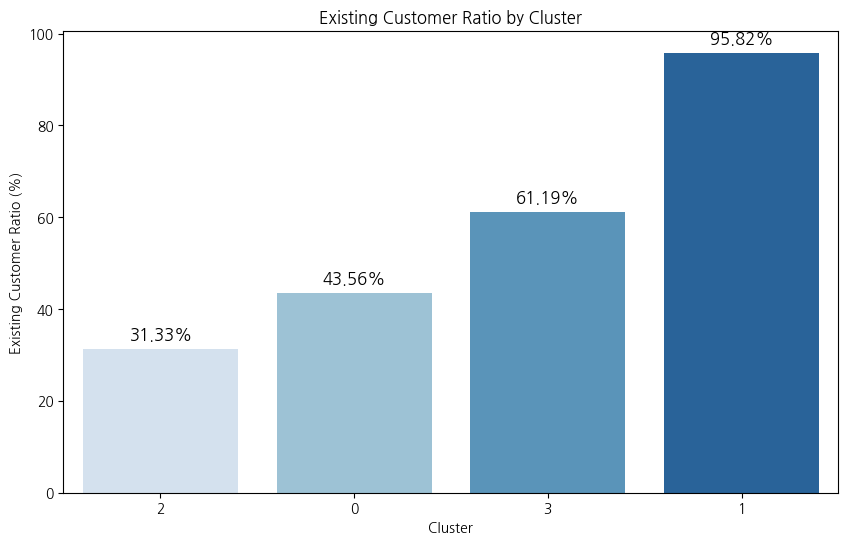

In [41]:
def calculate_customer_type_ratio():
    new_customer_ratio = {}
    existing_customer_ratio = {}

    for cluster in df['Cluster'].unique():
        existing_customers = df[(df['Cluster'] == cluster) & (df['최초거래년월'] == 202101)]
        new_customers = df[(df['Cluster'] == cluster) & (df['최초거래년월'] != 202101)]

        total_customers = len(existing_customers) + len(new_customers)
        new_customer_ratio[cluster] = len(new_customers) / total_customers * 100
        existing_customer_ratio[cluster] = len(existing_customers) / total_customers * 100

    return new_customer_ratio, existing_customer_ratio

new_customer_ratio, existing_customer_ratio = calculate_customer_type_ratio()

new_customer_df = pd.DataFrame(list(new_customer_ratio.items()), columns=['Cluster', 'New Customer Ratio'])
existing_customer_df = pd.DataFrame(list(existing_customer_ratio.items()), columns=['Cluster', 'Existing Customer Ratio'])

cluster_order = [2, 0, 3, 1]

plt.figure(figsize=(10, 6))
ax1 = sns.barplot(x='Cluster', y='New Customer Ratio', data=new_customer_df, palette='Blues', order=cluster_order)
plt.title('New Customer Ratio by Cluster')
plt.xlabel('Cluster')
plt.ylabel('New Customer Ratio (%)')

for i, value in enumerate(new_customer_df['New Customer Ratio']):
    ax1.text(i, value + 2, f'{value:.2f}%', ha='center', fontsize=12)

plt.show()

plt.figure(figsize=(10, 6))
ax2 = sns.barplot(x='Cluster', y='Existing Customer Ratio', data=existing_customer_df, palette='Blues', order=cluster_order)
plt.title('Existing Customer Ratio by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Existing Customer Ratio (%)')

for i, value in enumerate(existing_customer_df['Existing Customer Ratio']):
    ax2.text(i, value + 2, f'{value:.2f}%', ha='center', fontsize=12)

plt.show()

### 군집별 활성화율, 유지율

In [42]:
df_2 = df[df['Cluster'] == 2]
df_0 = df[df['Cluster'] == 0]
df_3 = df[df['Cluster'] == 3]
df_1 = df[df['Cluster'] == 1]

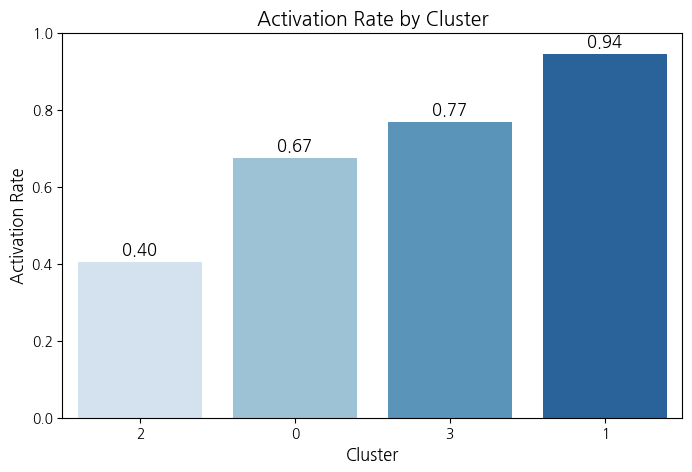

In [43]:
y_values = [
    len(df_2[df_2['활성화2'] == '활성화o']) / (len(df_2[df_2['활성화2'] == '활성화o']) + len(df_2[df_2['활성화2'] == '활성화x'])),
    len(df_0[df_0['활성화2'] == '활성화o']) / (len(df_0[df_0['활성화2'] == '활성화o']) + len(df_0[df_0['활성화2'] == '활성화x'])),
    len(df_3[df_3['활성화2'] == '활성화o']) / (len(df_3[df_3['활성화2'] == '활성화o']) + len(df_3[df_3['활성화2'] == '활성화x'])),
    len(df_1[df_1['활성화2'] == '활성화o']) / (len(df_1[df_1['활성화2'] == '활성화o']) + len(df_1[df_1['활성화2'] == '활성화x']))
]

clusters = ['2', '0', '3', '1']

palette = sns.color_palette('Blues', len(clusters))

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=clusters, y=y_values, palette=palette)

plt.ylim(0, 1)  # y축 범위 설정 (확률 값이므로 0~1)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Activation Rate', fontsize=12)
plt.title('Activation Rate by Cluster', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

for i, value in enumerate(y_values):
    ax.text(i, value + 0.02, f'{value:.2f}', ha='center', fontsize=12)

plt.show()

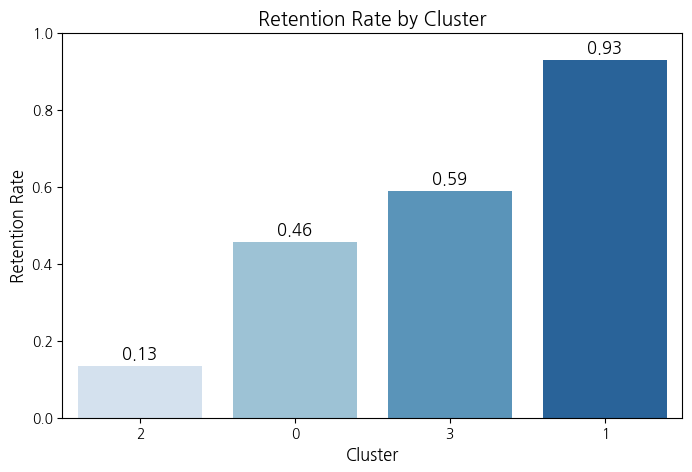

In [44]:
y_values = [
    len(df_2[df_2['신유지2'] == '신유지o']) / (len(df_2[df_2['신유지2'] == '신유지o']) + len(df_2[df_2['신유지2'] == '신유지x'])),
    len(df_0[df_0['신유지2'] == '신유지o']) / (len(df_0[df_0['신유지2'] == '신유지o']) + len(df_0[df_0['신유지2'] == '신유지x'])),
    len(df_3[df_3['신유지2'] == '신유지o']) / (len(df_3[df_3['신유지2'] == '신유지o']) + len(df_3[df_3['신유지2'] == '신유지x'])),
    len(df_1[df_1['신유지2'] == '신유지o']) / (len(df_1[df_1['신유지2'] == '신유지o']) + len(df_1[df_1['신유지2'] == '신유지x']))
]

clusters = ['2', '0', '3', '1']

palette = sns.color_palette('Blues', len(clusters))

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=clusters, y=y_values, palette=palette)

plt.ylim(0, 1) 
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Retention Rate', fontsize=12)
plt.title('Retention Rate by Cluster', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

for i, value in enumerate(y_values):
    ax.text(i, value + 0.02, f'{value:.2f}', ha='center', fontsize=12)

plt.show()

# 몬테 카를로
- 이탈 군집과 부거래 군집에 대한 혜택 비용 산정 몬테카를로 시뮬레이션 과정 예시 설명
1. 이탈 군집 100명 중 40명이 1만원 혜택만을 사용하기 위해 들어옴
2. 40명의 고객들이 각각 3만원의 결제에 1만원 혜택 적용
3. 쿠폰 금액(40만원) - 카드 수수료(3만원 * 0.01 * 40) = 38만 8천원 손해 
4. 이탈 군집의 유지율 만큼 2개월 더 거래하는 고객 발생 (13명)
5. 13명의 월평균 거래금액 * 2개월 * 0.01 = 이익 
6. 손해 대비 이익이 커지는 혜택 비용을 산정하기 위한 시뮬레이션

In [48]:
df_2['1회 평균 거래금액'] = df_2['월평균 거래금액'] /df_2['월평균 거래건수']
df_0['1회 평균 거래금액'] = df_0['월평균 거래금액'] /df_0['월평균 거래건수']

### 먼저 이탈 군집에 대해 혜택 비용 산정 시뮬레이션
- 이탈 군집의 활성화율 만큼 혜택 비용을 사용하고 빠져나감
- 이탈 군집의 유지율 만큼을 잡는다고 생각하고 투자 진행

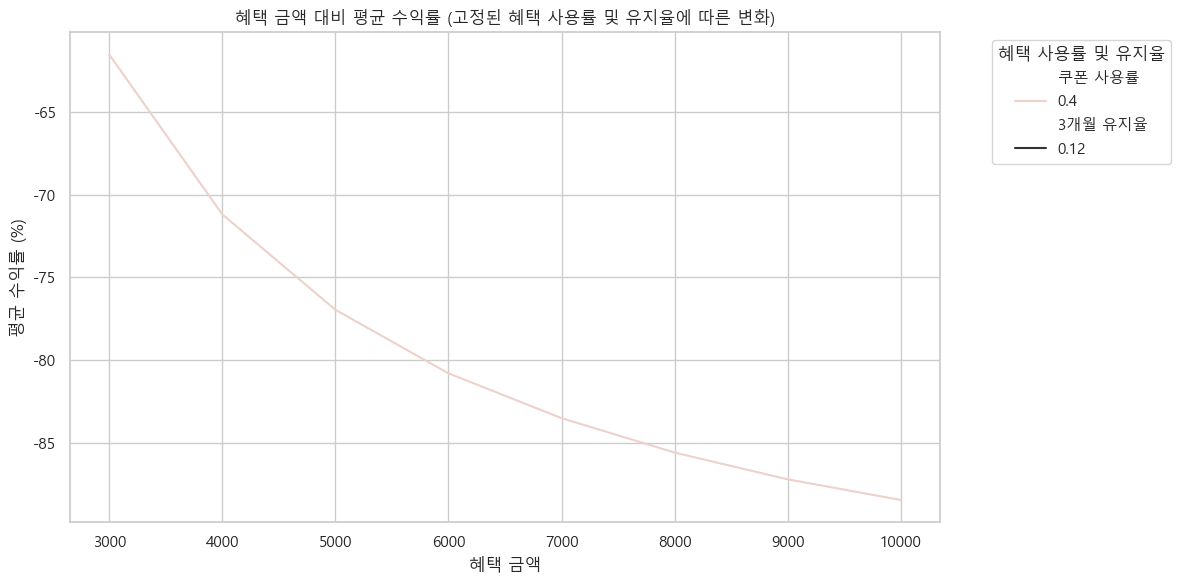

In [51]:
def simulate_revenue_change(df_2, coupon_amount, new_customer_rate, long_term_3month_rate):
    coupon_users_count = int(len(df_2) * new_customer_rate)
    coupon_users = np.random.choice(df_2.index, coupon_users_count, replace=False)
    customer_spendings = df_2['월평균 거래금액'].values
    coupon_usage = np.isin(df_2.index, coupon_users).astype(int)
    coupon_cost = coupon_usage * coupon_amount
    
    revenue_from_coupon_customers = coupon_usage * df_2['1회 평균 거래금액'] * 0.01
    
    long_term_3month_customers_count = int(len(coupon_users) * long_term_3month_rate)
    long_term_3month_customers = np.random.choice(coupon_users, long_term_3month_customers_count, replace=False)
    long_term_revenue = np.isin(df_2.index, long_term_3month_customers).astype(int) * customer_spendings * 0.01 * 3  # 3개월로 변경
    
    total_revenue = revenue_from_coupon_customers + long_term_revenue
    revenue_change = np.sum(total_revenue) - np.sum(coupon_cost)
    roi = revenue_change / np.sum(coupon_cost) if np.sum(coupon_cost) > 0 else 0
    return revenue_change, roi

num_simulations = 5000
coupon_amounts = np.arange(3000, 10001, 1000)  
customer_rate = 0.4  
long_term_rate = 0.12  

simulation_results = []

for coupon_amount in coupon_amounts:
    revenue_changes, rois = [], []
    
    for _ in range(num_simulations): 
        revenue_change, roi = simulate_revenue_change(df_2, coupon_amount, customer_rate, long_term_rate)
        revenue_changes.append(revenue_change)
        rois.append(roi)
    
    avg_revenue_change = np.mean(revenue_changes)
    avg_roi = np.mean(rois)
    simulation_results.append({
        '쿠폰금액': coupon_amount,
        '쿠폰 사용률': customer_rate,
        '3개월 유지율': long_term_rate,  
        '평균 수익률': avg_roi * 100
    })

results_df = pd.DataFrame(simulation_results)

sns.set(style="whitegrid")

plt.rcParams['font.family'] = 'Malgun Gothic'  
plt.rcParams['axes.unicode_minus'] = False   

fig, axes = plt.subplots(1, 1, figsize=(12, 6))

sns.lineplot(
    data=results_df,
    x="쿠폰금액",
    y="평균 수익률",
    hue="쿠폰 사용률",
    style="3개월 유지율",
    ax=axes
)
axes.set_title("혜택 금액 대비 평균 수익률 (고정된 혜택 사용률 및 유지율에 따른 변화)")
axes.set_ylabel("평균 수익률 (%)")
axes.set_xlabel("혜택 금액")
axes.legend(title="혜택 사용률 및 유지율", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### 이어서 부거래 군집에 대해서도 활성화율과 유지율을 가져와서 동일하게 적용

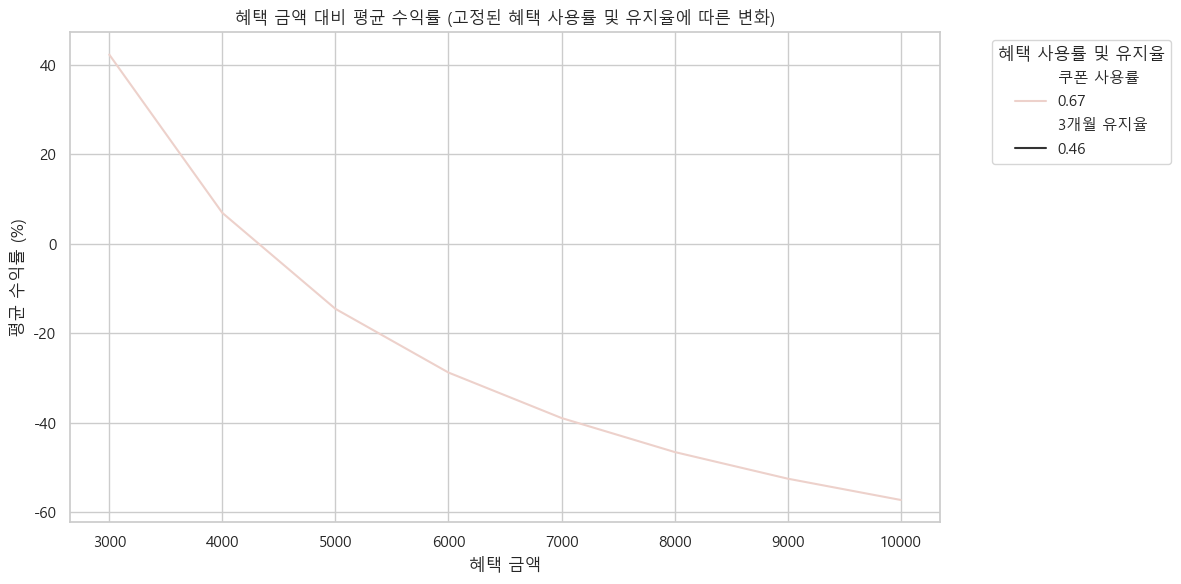

In [52]:
def simulate_revenue_change(df_0, coupon_amount, new_customer_rate, long_term_3month_rate):
    coupon_users_count = int(len(df_0) * new_customer_rate)
    coupon_users = np.random.choice(df_0.index, coupon_users_count, replace=False)
    customer_spendings = df_0['월평균 거래금액'].values
    coupon_usage = np.isin(df_0.index, coupon_users).astype(int)
    coupon_cost = coupon_usage * coupon_amount
   
    revenue_from_coupon_customers = coupon_usage * df_0['1회 평균 거래금액'] * 0.01
   
    long_term_3month_customers_count = int(len(coupon_users) * long_term_3month_rate)
    long_term_3month_customers = np.random.choice(coupon_users, long_term_3month_customers_count, replace=False)
    long_term_revenue = np.isin(df_0.index, long_term_3month_customers).astype(int) * customer_spendings * 0.01 * 3  # 3개월로 변경
   
    total_revenue = revenue_from_coupon_customers + long_term_revenue
    revenue_change = np.sum(total_revenue) - np.sum(coupon_cost)
    roi = revenue_change / np.sum(coupon_cost) if np.sum(coupon_cost) > 0 else 0
    return revenue_change, roi

num_simulations = 5000
coupon_amounts = np.arange(3000, 10001, 1000) 
customer_rate = 0.67  
long_term_rate = 0.46  

simulation_results = []

for coupon_amount in coupon_amounts:
    revenue_changes, rois = [], []
    
    for _ in range(num_simulations): 
        revenue_change, roi = simulate_revenue_change(df_0, coupon_amount, customer_rate, long_term_rate)
        revenue_changes.append(revenue_change)
        rois.append(roi)
    
    avg_revenue_change = np.mean(revenue_changes)
    avg_roi = np.mean(rois)
    simulation_results.append({
        '쿠폰금액': coupon_amount,
        '쿠폰 사용률': customer_rate,
        '3개월 유지율': long_term_rate,  
        '평균 수익률': avg_roi * 100
    })

results_df = pd.DataFrame(simulation_results)

sns.set(style="whitegrid")

plt.rcParams['font.family'] = 'Malgun Gothic' 
plt.rcParams['axes.unicode_minus'] = False  

fig, axes = plt.subplots(1, 1, figsize=(12, 6))

sns.lineplot(
    data=results_df,
    x="쿠폰금액",
    y="평균 수익률",
    hue="쿠폰 사용률",
    style="3개월 유지율", 
    ax=axes
)
axes.set_title("혜택 금액 대비 평균 수익률 (고정된 혜택 사용률 및 유지율에 따른 변화)")
axes.set_ylabel("평균 수익률 (%)")
axes.set_xlabel("혜택 금액")
axes.legend(title="혜택 사용률 및 유지율", bbox_to_anchor=(1.05, 1), loc='upper left')

# 그래프 레이아웃 조정
plt.tight_layout()
plt.show()